In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.integrate import odeint, ode, solve_ivp
import seaborn as sns
from copy import deepcopy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from scipy import interpolate
from scipy.interpolate import CubicSpline
import warnings
warnings.filterwarnings("ignore")
%run -i '../../../../../utils.py'

# Read data

In [13]:
# read metadata
df_meta = pd.read_excel('../../../../../our_data/meta_data.xlsx', index_col=0)
df_meta = df_meta[df_meta.Diet=='Inulin']
df_meta = df_meta.drop('Diet', axis=1)
df_meta = df_meta.rename({'MiceID':'SubjectID'}, axis=1)

# read SCFA
df_scfa = pd.read_excel('../../../../../our_data/SCFA.xlsx', index_col=0)

# read bacterial absolute abundance
df_bac = pd.read_excel('../../../../../our_data/16S_absolute_abundance.xlsx', index_col=0)
df_bac = df_bac/df_bac.max().max()

# Intrapolation

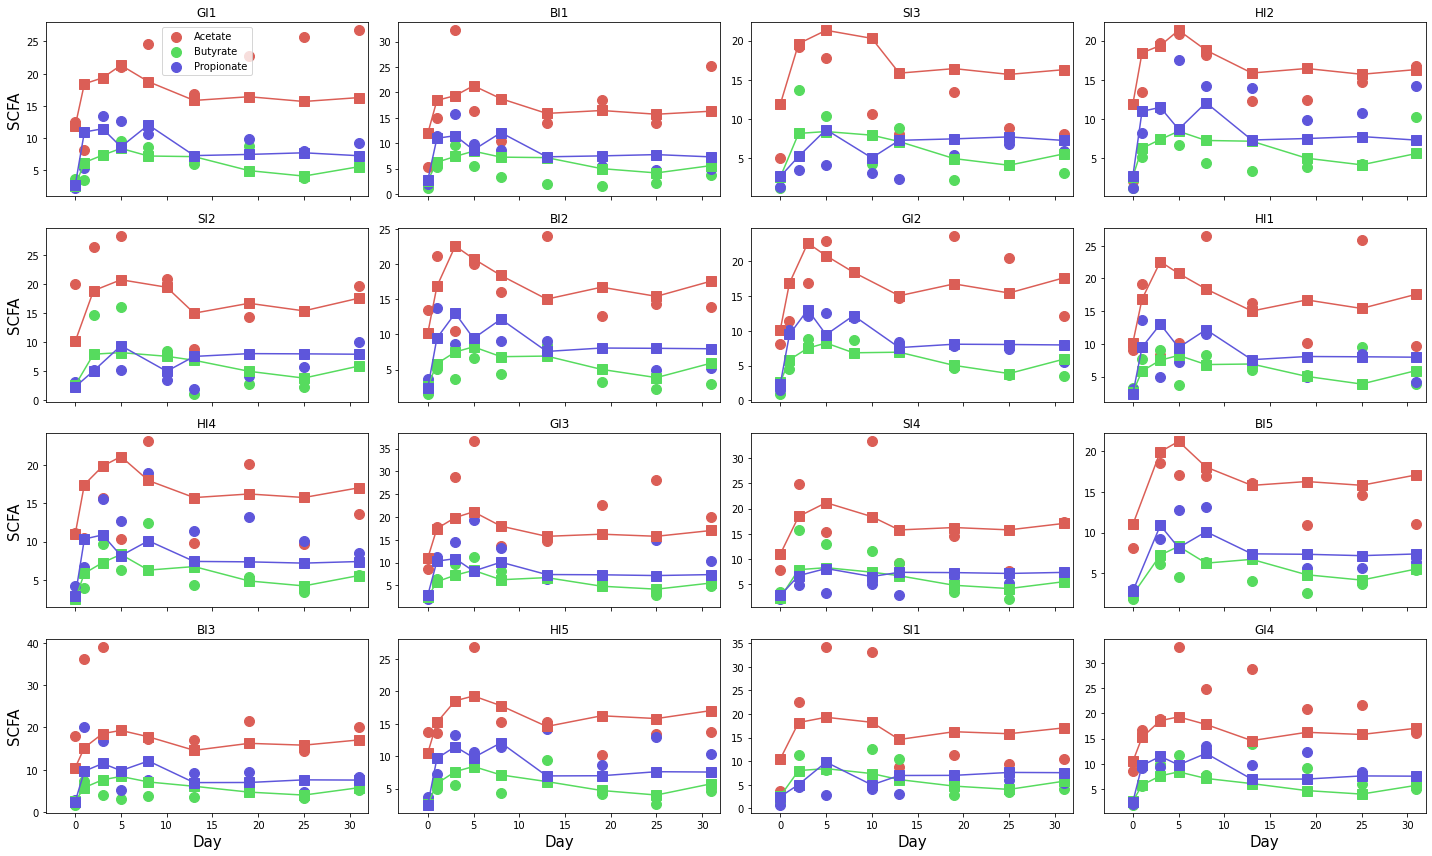

In [7]:
df_intra = get_rf_prediction_error(
    df_meta=df_meta,
    df_scfa=df_scfa,
    df_bac=df_bac,
    target_scfa=['Acetate','Butyrate','Propionate'],
    prediction_type='intrapolation',
    topN=40,
    is_plot=True,
    save_fig=False,
    use_deriv_scfa=False,
    use_deriv_microbiome=None
)
df_intra.to_csv('prediction_error_intrapolation.csv')

# Extrapolation

[0, 1, 2, 3, 5, 8, 10, 13, 19, 25, 31]
Index([              'SubjectID_x',                  'Vendor_x',
                           'Day_x',         'RandomizedGroup_x',
                     'SubjectID_y',                  'Vendor_y',
                           'Day_y',         'RandomizedGroup_y',
          'Acetate_value_observed',   'Butyrate_value_observed',
       'Propionate_value_observed',                 'SubjectID',
                          'Vendor',                       'Day',
                 'RandomizedGroup',    'Acetate_deriv_observed',
         'Butyrate_deriv_observed', 'Propionate_deriv_observed',
                                 0,                           1,
                                 3,                           5,
                                 8,                          13,
                                19,                          25,
                                31],
      dtype='object')


KeyError: '[2, 10] not in index'

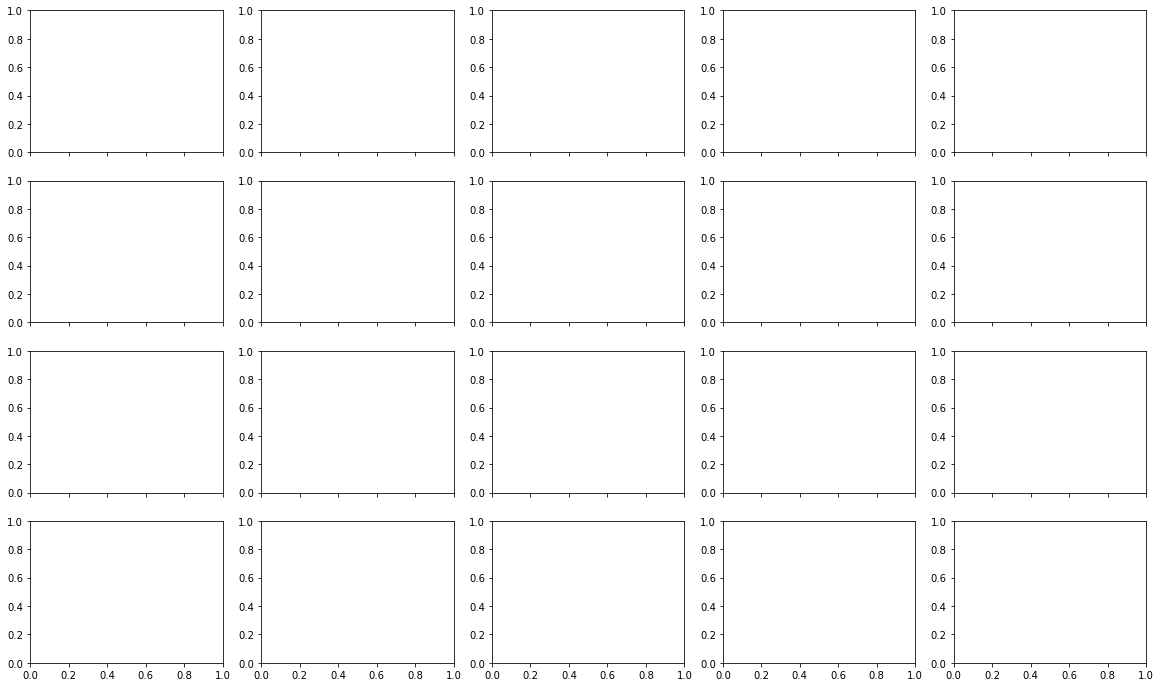

In [11]:
df_extra = get_rf_prediction_error(
    df_meta=df_meta,
    df_scfa=df_scfa,
    df_bac=df_bac,
    target_scfa=['Acetate','Butyrate','Propionate'],
    prediction_type='extrapolation',
    topN=40,
    is_plot=True,
    save_fig=False,
    use_deriv_scfa=False,
    use_deriv_microbiome=None
)
df_extra.to_csv('prediction_error_extrapolation.csv')

In [ ]:
df_intra = pd.read_csv('prediction_error_intrapolation.csv', index_col=0)
df_intra['Perturbation'] = 'intrapolation'
df_extra = pd.read_csv('prediction_error_extrapolation.csv', index_col=0)
df_extra['Perturbation'] = 'extrapolation'
df_train_test = pd.concat([df_intra,df_extra], ignore_index=True)
df_train_test.to_csv('prediction_error_combined.csv')
df_train_test.head()

# Scatter plot of observed vs. computed SCFA concentrations

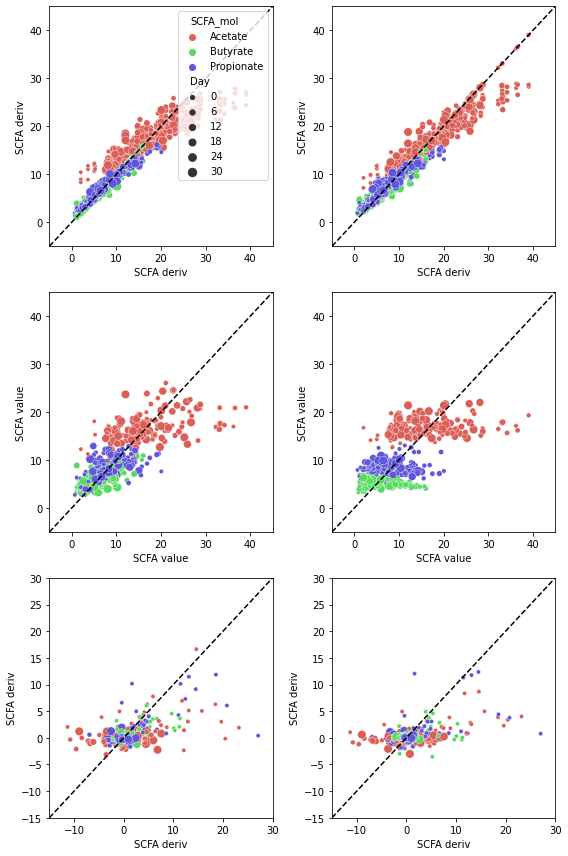

In [13]:
fig, ax = plt.subplots(figsize=(8,12), nrows=3, ncols=2)

# training, intrapolation
df = pd.read_csv('intrapolation/training_error_intrapolation.csv')
_ = sns.scatterplot(x='SCFA_observed',y='SCFA_predicted', hue='SCFA_mol', size='Day', palette=sns.color_palette("hls", 3), data=df, ax=ax[0,0])
_ = ax[0,0].plot([-5,45],[-5,45],'k--')
_ = ax[0,0].set_xlim([-5,45])
_ = ax[0,0].set_ylim([-5,45])
_ = ax[0,0].set_xlabel('SCFA deriv')
_ = ax[0,0].set_ylabel('SCFA deriv')

# training, extrapolation
df = pd.read_csv('extrapolation/training_error_extrapolation.csv')
_ = sns.scatterplot(x='SCFA_observed',y='SCFA_predicted', hue='SCFA_mol', size='Day', palette=sns.color_palette("hls", 3), data=df, ax=ax[0,1])
_ = ax[0,1].plot([-5,45],[-5,45],'k--')
_ = ax[0,1].set_xlim([-5,45])
_ = ax[0,1].set_ylim([-5,45])
_ = ax[0,1].set_xlabel('SCFA deriv')
_ = ax[0,1].set_ylabel('SCFA deriv')
_ = ax[0,1].legend().remove()

# testing
for i,quantity in enumerate(['value','deriv']):
    for k,perturbation in enumerate(['intrapolation','extrapolation']):
        df = df_train_test[df_train_test.Perturbation==perturbation]
        _ = sns.scatterplot(x='SCFA_%s_observed'%(quantity),y='SCFA_%s_predicted'%(quantity), hue='SCFA_mol', size='Day', palette=sns.color_palette("hls", 3), data=df, ax=ax[i+1,k])
        if quantity=='value':
            _ = ax[i+1,k].plot([-5,45],[-5,45],'k--')
            _ = ax[i+1,k].set_xlim([-5,45])
            _ = ax[i+1,k].set_ylim([-5,45])
        else:
            _ = ax[i+1,k].plot([-15,30],[-15,30],'k--')
            _ = ax[i+1,k].set_xlim([-15,30])
            _ = ax[i+1,k].set_ylim([-15,30])
        ax[i+1,k].legend().remove()
        _ = ax[i+1,k].set_xlabel('SCFA %s'%(quantity))
        _ = ax[i+1,k].set_ylabel('SCFA %s'%(quantity))
            
plt.tight_layout()

df_R2 = pd.DataFrame(lines_R2, columns=['Perturbation','Train_or_test','Value_or_deriv','SCFA','R2','PCC'])

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("scatter_plot_training_prediction.svg", format="svg")

# Plot R2 (combine for all test tests)

In [42]:
lines_R2 = []

# training, intrapolation
curr_df_train = pd.read_csv('intrapolation/training_error_intrapolation.csv', index_col=0)
r2_ac = r2_score(curr_df_train[curr_df_train.SCFA_mol=='Acetate'].SCFA_observed, curr_df_train[curr_df_train.SCFA_mol=='Acetate'].SCFA_predicted)
r2_but = r2_score(curr_df_train[curr_df_train.SCFA_mol=='Butyrate'].SCFA_observed, curr_df_train[curr_df_train.SCFA_mol=='Butyrate'].SCFA_predicted)
r2_ppa = r2_score(curr_df_train[curr_df_train.SCFA_mol=='Propionate'].SCFA_observed, curr_df_train[curr_df_train.SCFA_mol=='Propionate'].SCFA_predicted)
lines_R2.append(['intrapolation','training','value','acetate',r2_ac])
lines_R2.append(['intrapolation','training','value','butyrate',r2_but])
lines_R2.append(['intrapolation','training','value','propionate',r2_ppa])

# training, extrapolation
curr_df_train = pd.read_csv('extrapolation/training_error_extrapolation.csv', index_col=0)
r2_ac = r2_score(curr_df_train[curr_df_train.SCFA_mol=='Acetate'].SCFA_observed, curr_df_train[curr_df_train.SCFA_mol=='Acetate'].SCFA_predicted)
r2_but = r2_score(curr_df_train[curr_df_train.SCFA_mol=='Butyrate'].SCFA_observed, curr_df_train[curr_df_train.SCFA_mol=='Butyrate'].SCFA_predicted)
r2_ppa = r2_score(curr_df_train[curr_df_train.SCFA_mol=='Propionate'].SCFA_observed, curr_df_train[curr_df_train.SCFA_mol=='Propionate'].SCFA_predicted)
lines_R2.append(['extrapolation','training','value','acetate',r2_ac])
lines_R2.append(['extrapolation','training','value','butyrate',r2_but])
lines_R2.append(['extrapolation','training','value','propionate',r2_ppa])

# testing
for i,quantity in enumerate(['value','deriv']):
    for perturbation in ['intrapolation','extrapolation']:
        df_test = df_train_test[df_train_test.Perturbation==perturbation]
        r2_ac = r2_score(df_test[df_test.SCFA_mol=='Acetate']['SCFA_%s_observed'%(quantity)], df_test[df_test.SCFA_mol=='Acetate']['SCFA_%s_predicted'%(quantity)])
        r2_but = r2_score(df_test[df_test.SCFA_mol=='Butyrate']['SCFA_%s_observed'%(quantity)], df_test[df_test.SCFA_mol=='Butyrate']['SCFA_%s_predicted'%(quantity)])
        r2_ppa = r2_score(df_test[df_test.SCFA_mol=='Propionate']['SCFA_%s_observed'%(quantity)], df_test[df_test.SCFA_mol=='Propionate']['SCFA_%s_predicted'%(quantity)])
        lines_R2.append([perturbation,'testing',quantity,'acetate',r2_ac])
        lines_R2.append([perturbation,'testing',quantity,'butyrate',r2_but])
        lines_R2.append([perturbation,'testing',quantity,'propionate',r2_ppa])
                
df_R2 = pd.DataFrame(lines_R2, columns=['Perturbation','Train_or_test','Value_or_deriv','SCFA','R2'])

df_R2.head()

,Perturbation,Train_or_test,Value_or_deriv,SCFA,R2
0,intrapolation,training,value,acetate,0.726619
1,intrapolation,training,value,butyrate,0.965945
2,intrapolation,training,value,propionate,0.951722
3,extrapolation,training,value,acetate,0.857416
4,extrapolation,training,value,butyrate,0.898382


## SCFA concentration

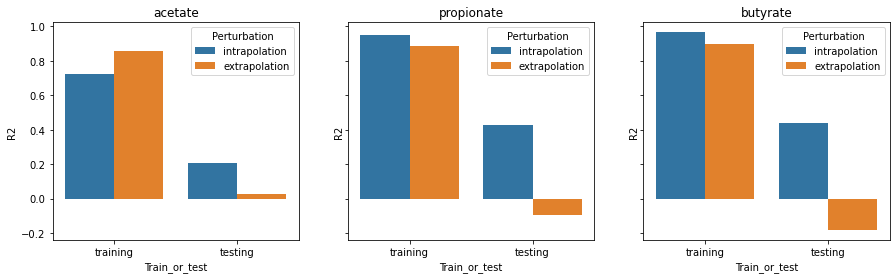

In [43]:
df_R2_tmp = df_R2[df_R2.Value_or_deriv=='value']

fig,ax = plt.subplots(figsize=(15,4), nrows=1, ncols=3, sharey=True)
for k,scfa_ in enumerate(['acetate','propionate','butyrate']):
    _=sns.barplot(x='Train_or_test', y='R2', hue='Perturbation', data=df_R2_tmp[df_R2_tmp.SCFA==scfa_], ax=ax[k])
    ax[k].set_title(scfa_)

# Plot R2 (separate for each test set)

In [34]:
lines_R2 = []

# training, intrapolation
df_train = pd.read_csv('intrapolation/training_error_intrapolation.csv', index_col=0)
for label in set(df_train.TrainSetLabel):
    curr_df_train = df_train[df_train.TrainSetLabel==label]
    r2_ac = r2_score(curr_df_train[curr_df_train.SCFA_mol=='Acetate'].SCFA_observed, curr_df_train[curr_df_train.SCFA_mol=='Acetate'].SCFA_predicted)
    r2_but = r2_score(curr_df_train[curr_df_train.SCFA_mol=='Butyrate'].SCFA_observed, curr_df_train[curr_df_train.SCFA_mol=='Butyrate'].SCFA_predicted)
    r2_ppa = r2_score(curr_df_train[curr_df_train.SCFA_mol=='Propionate'].SCFA_observed, curr_df_train[curr_df_train.SCFA_mol=='Propionate'].SCFA_predicted)
    lines_R2.append(['intrapolation','training','value',label,'acetate',r2_ac])
    lines_R2.append(['intrapolation','training','value',label,'butyrate',r2_but])
    lines_R2.append(['intrapolation','training','value',label,'propionate',r2_ppa])

# training, extrapolation
df_train = pd.read_csv('extrapolation/training_error_extrapolation.csv', index_col=0)
for label in set(df_train.TrainSetLabel):
    curr_df_train = df_train[df_train.TrainSetLabel==label]
    r2_ac = r2_score(curr_df_train[curr_df_train.SCFA_mol=='Acetate'].SCFA_observed, curr_df_train[curr_df_train.SCFA_mol=='Acetate'].SCFA_predicted)
    r2_but = r2_score(curr_df_train[curr_df_train.SCFA_mol=='Butyrate'].SCFA_observed, curr_df_train[curr_df_train.SCFA_mol=='Butyrate'].SCFA_predicted)
    r2_ppa = r2_score(curr_df_train[curr_df_train.SCFA_mol=='Propionate'].SCFA_observed, curr_df_train[curr_df_train.SCFA_mol=='Propionate'].SCFA_predicted)
    lines_R2.append(['extrapolation','training','value',label,'acetate',r2_ac])
    lines_R2.append(['extrapolation','training','value',label,'butyrate',r2_but])
    lines_R2.append(['extrapolation','training','value',label,'propionate',r2_ppa])

# testing
for i,quantity in enumerate(['value','deriv']):
    # intrapolation
    df_test_intra = df_train_test[df_train_test.Perturbation=='intrapolation']
    for group in set(df_test_intra.RandomizedGroup):
        df_test = df_test_intra[df_test_intra.RandomizedGroup==group]
        r2_ac = r2_score(df_test[df_test.SCFA_mol=='Acetate']['SCFA_%s_observed'%(quantity)], df_test[df_test.SCFA_mol=='Acetate']['SCFA_%s_predicted'%(quantity)])
        r2_but = r2_score(df_test[df_test.SCFA_mol=='Butyrate']['SCFA_%s_observed'%(quantity)], df_test[df_test.SCFA_mol=='Butyrate']['SCFA_%s_predicted'%(quantity)])
        r2_ppa = r2_score(df_test[df_test.SCFA_mol=='Propionate']['SCFA_%s_observed'%(quantity)], df_test[df_test.SCFA_mol=='Propionate']['SCFA_%s_predicted'%(quantity)])
        lines_R2.append(['intrapolation','testing',quantity,'ExcludeGroup'+group,'acetate',r2_ac])
        lines_R2.append(['intrapolation','testing',quantity,'ExcludeGroup'+group,'butyrate',r2_but])
        lines_R2.append(['intrapolation','testing',quantity,'ExcludeGroup'+group,'propionate',r2_ppa])
    # extrapolation
    df_test_extra = df_train_test[df_train_test.Perturbation=='extrapolation']
    for vendor in set(df_test_extra.Vendor):
        df_test = df_test_extra[df_test_extra.Vendor==vendor]
        r2_ac = r2_score(df_test[df_test.SCFA_mol=='Acetate']['SCFA_%s_observed'%(quantity)], df_test[df_test.SCFA_mol=='Acetate']['SCFA_%s_predicted'%(quantity)])
        r2_but = r2_score(df_test[df_test.SCFA_mol=='Butyrate']['SCFA_%s_observed'%(quantity)], df_test[df_test.SCFA_mol=='Butyrate']['SCFA_%s_predicted'%(quantity)])
        r2_ppa = r2_score(df_test[df_test.SCFA_mol=='Propionate']['SCFA_%s_observed'%(quantity)], df_test[df_test.SCFA_mol=='Propionate']['SCFA_%s_predicted'%(quantity)])
        lines_R2.append(['extrapolation','testing',quantity,'ExcludeVendor'+vendor,'acetate',r2_ac])
        lines_R2.append(['extrapolation','testing',quantity,'ExcludeVendor'+vendor,'butyrate',r2_but])
        lines_R2.append(['extrapolation','testing',quantity,'ExcludeVendor'+vendor,'propionate',r2_ppa])
            
df_R2 = pd.DataFrame(lines_R2, columns=['Perturbation','Train_or_test','Value_or_deriv','Train/Test_set_label','SCFA','R2'])

df_R2.head()

,Perturbation,Train_or_test,Value_or_deriv,Train/Test_set_label,SCFA,R2
0,intrapolation,training,value,ExcludeGroupD,acetate,0.729097
1,intrapolation,training,value,ExcludeGroupD,butyrate,1.000000
2,intrapolation,training,value,ExcludeGroupD,propionate,0.920398
3,intrapolation,training,value,ExcludeGroupC,acetate,0.650097
4,intrapolation,training,value,ExcludeGroupC,butyrate,0.862118


## SCFA concentration

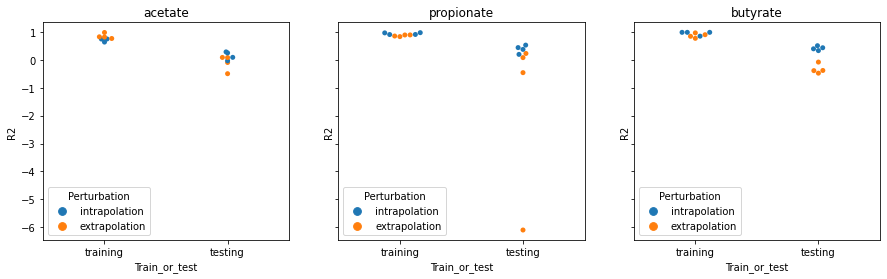

In [40]:
df_R2_tmp = df_R2[df_R2.Value_or_deriv=='value']

fig,ax = plt.subplots(figsize=(15,4), nrows=1, ncols=3, sharey=True)
for k,scfa_ in enumerate(['acetate','propionate','butyrate']):
    _=sns.swarmplot(x='Train_or_test', y='R2', hue='Perturbation', data=df_R2_tmp[df_R2_tmp.SCFA==scfa_], ax=ax[k])
    ax[k].set_title(scfa_)